__Vu H. Chu-Le__


___

# Introduction

In this assignment, we model the cost of groceries in different neighborhoods of Berlin. Does
the store brand affect product prices, or not? Are grocery prices and the geographical distribution of
different grocery stores correlated with other cost-of-living measures in a city — for example, rent and
real estate prices? 

**Questions to answer:**

* What is the basic average price for each product?
* How much does each of the following factors modify the basic price of the product (up or down)?
  * Brand of the grocery store.
  * The geographical location of the grocery store.
  * Does price variation by geographical location correlate with variation in rental prices or not? Use a map of rental prices in Berlin by U-Bahn and S-Bahn station.



___

# Clean up data

In [3]:
# Read data from file
import pandas as pd

data = pd.read_csv("LBA_data.csv", skiprows=[0, 2], 
                   usecols=lambda x: x not in ['Email Address', 'Your name'])
data.head()

,Timestamp,Grocery store,Grocery store street address,Product 1 quantity (kg),Product 1 price (€),Product 2 quantity (kg),Product 2 price (€),Product 3 quantity (kg),Product 3 price (€),Product 1 quantity (kg).1,Product 1 price (€).1,Product 2 quantity (kg).1,Product 2 price (€).1,Product 3 quantity (kg).1,Product 3 price (€).1,Product 1 quantity (kg).2,Product 1 price (€).2,Product 2 quantity (kg).2,Product 2 price (€).2,Product 3 quantity (kg).2,Product 3 price (€).2,Product 1 quantity (kg).3,Product 1 price (€).3,Product 2 quantity (kg).3,Product 2 price (€).3,Product 3 quantity (kg).3,Product 3 price (€).3,Product 1 quantity (kg).4,Product 1 price (€).4,Product 2 quantity (kg).4,Product 2 price (€).4,Product 3 quantity (kg).4,Product 3 price (€).4,Product 1 quantity (kg).5,Product 1 price (€).5,Product 2 quantity (kg).5,Product 2 price (€).5,Product 3 quantity (kg).5,Product 3 price (€).5,Product 1 quantity (liters),Product 1 price (€).6,Product 2 quantity (liters),Product 2 price (€).6,Product 3 quantity (liters),Product 3 price (€).6,Product 1 quantity (kg).6,Product 1 price (€).7,Product 2 quantity (kg).6,Product 2 price (€).7,Product 3 quantity (kg).6,Product 3 price (€).7,Product 1 quantity (count),Product 1 price (€).8,Product 2 quantity (count),Product 2 price (€).8,Product 3 quantity (count),Product 3 price (€).8,Product 1 quantity (kg).7,Product 1 price (€).9,Product 2 quantity (kg).7,Product 2 price (€).9,Product 3 quantity (kg).7,Product 3 price (€).9
0,10/28/2019 13:14:59,ALDI,Rummelsburger Str. 98,0.88,2.20,1.00,1.88,0.6,1.89,1.0,1.69,1.0,0.99,NaN,NaN,0.65,2.29,0.5,1.49,1.00,1.89,2.5,1.39,5.0,2.49,2.0,2.49,1.0,0.39,NaN,NaN,NaN,NaN,1.00,1.99,NaN,NaN,NaN,NaN,1.0,0.99,0.20,0.63,1.0,0.99,0.25,1.39,0.25,1.59,0.25,2.39,10,1.19,6.0,1.59,10.0,1.59,0.60,3.99,1.000,5.99,NaN,NaN
1,10/29/2019 14:19:19,REWE,Karl-Marx-Straße 92-98,1.00,2.49,1.00,1.49,1.0,2.49,1.0,0.99,1.0,1.69,1.0,1.59,0.10,0.69,0.5,2.29,0.35,1.99,3.0,1.69,1.0,2.49,1.5,2.29,1.0,0.39,0.5,0.69,1.0,0.79,0.25,1.79,0.50,1.99,0.24,2.49,1.0,1.29,1.00,1.39,1.0,0.79,0.25,1.39,0.25,1.39,0.25,2.39,6,1.69,1.0,0.25,6.0,1.59,1.00,13.90,1.000,9.99,1.000,9.98
2,10/29/2019 21:22:30,ALDI,"Hermannstraße 72, 12049 Berlin, Germany",1.00,2.99,1.00,1.79,0.8,1.89,1.0,1.15,1.0,1.69,2.0,2.99,0.50,1.79,1.0,1.99,0.50,2.29,2.5,1.39,2.0,2.65,5.0,3.99,1.0,0.39,1.0,1.49,1.0,1.39,0.50,1.99,NaN,NaN,NaN,NaN,1.0,1.05,1.00,0.71,1.0,0.99,0.25,2.39,0.25,1.29,0.25,1.29,10,1.59,10.0,1.19,6.0,1.59,0.60,3.99,1.000,5.99,0.350,3.99
3,10/30/2019 16:20:11,Lidl,"Lidl, Leipziger Str. 42",1.00,1.79,0.75,1.99,0.8,1.89,1.0,1.09,1.0,1.69,1.0,1.19,0.35,2.49,1.0,1.89,0.50,1.79,1.0,0.75,2.5,1.39,NaN,NaN,1.0,0.39,1.0,0.89,NaN,NaN,0.50,1.49,0.25,1.59,1.00,1.99,1.0,1.05,1.00,1.29,1.0,1.15,0.25,2.39,0.25,1.59,0.25,1.69,10,1.19,10.0,1.69,10.0,2.65,0.60,3.99,0.400,2.79,NaN,NaN
4,10/30/2019 16:24:57,REWE,"REWE, Landsberger Allee 68D",0.65,2.49,1.00,2.19,1.0,1.49,1.0,0.99,1.0,1.89,1.0,1.59,1.00,1.99,0.5,1.99,0.50,2.29,3.0,1.69,1.5,2.29,1.0,1.49,1.0,0.79,1.0,0.39,1.0,0.79,0.50,2.79,1.00,1.99,0.50,4.99,0.5,0.95,0.55,0.42,1.0,0.71,0.25,1.99,0.25,1.39,0.25,2.39,6,1.99,6.0,2.29,12.0,1.99,0.41,5.34,0.249,2.49,0.285,8.52


### Get neighbourhood/locality using Google Maps API

Since rental price is provided by U-Bahn and S-Bahn station, for each store in Germany, search for the nearest train station to signify the store's location. The dataframe includes data collected by students in cities outside of Germany as well, but here we are considering only those in Germany, so a check for country is included.

We can imagine that since there are many train stations around, chances are that many stores would not share their closest station (we define neighborhood based on closest train stations for stores in Berlin) with any other store. This would create high bias and low variance, since the multiplier would be fitted to only one store, which is recorded by one person and can have instrumental/recording errors. To avoid that, we keep the top 3 closest stations to the store instead, and use the next closest station if the top choice is not shared with any other store. If the none of the 3 stations are shared by at least another store, then still go with the closest station.

A caveat for this is that for now we do not control how comparable the distances between the store and each of the stations are, and hence will still result in non-maximal performance. For example, if the closest station is 1 mile away and the next closest one is 5 miles away, it makes more sense to stay with the closer one rather than blindly choose according to the method as 5 miles away is probably already in another neighborhood.

In [5]:
import googlemaps
# Set up
api_key = SECRET_KEY
gmaps = googlemaps.Client(key=api_key)

berlin_index = []
def get_stations():
    """Find the top 3 closest train stations for only the addresses in Germany"""
    for i in range(len(data.index)):
        geocode_result = gmaps.geocode(data.iloc[i, 2])[0]
        if geocode_result['address_components'][-2]['long_name']=='Germany':
            berlin_index.append(i)
            location = geocode_result['geometry']['location']
            search_result = gmaps.places_nearby(location=location, 
                                            rank_by='distance', 
                                            type='train_station')
            yield [search_result['results'][i]['name'] for i in range(3)]

berlin_data = pd.DataFrame.from_records([*get_stations()])

Looking at all the unique values for train stations below, there are some stations that are actually the same one listed on Google Maps under different names. Therefore, we replace the duplicative values so that they have the same name.

In [6]:
berlin_data.stack().unique()

array(['Betriebsbahnhof Rummelsburg', 'Nöldnerplatz', 'Rummelsburg',
       'Berlin-Neukölln', 'Hermannstraße', 'S Sonnenallee',
       'Brandenburger Tor', 'Anhalter Bahnhof',
       'Berlin Friedrichstraße station', 'S Landsberger Allee',
       'S Storkower Str. (Berlin)', 'S Greifswalder Str.',
       'S+U Warschauer Str. (Berlin)', 'Treptower Park',
       'Berlin Ostbahnhof', 'Berlin Alexanderplatz Bahnhof',
       'Jannowitzbrücke', 'Hackescher Markt', 'Köllnische Heide station',
       'Berlin Potsdamer Platz Bahnhof', 'Frankfurter Allee',
       'Yorckstraße', 'Yorckstraße (Großgörschenstraße)',
       'Julius-Leber-Brücke', 'Prenzlauer Allee', 'Schönhauser Allee',
       'Berlin Ostkreuz Station', 'Berlin Nordbahnhof', 'Humboldthain',
       'Berlin Central Station', 'Bahnhof Berlin-Plänterwald',
       'S Poelchaustr. (Berlin)', 'Oranienburger Straße',
       'S-Bahnhof Hackescher Markt', 'Berlin Hbf', 'S+U Lichtenberg',
       'Berlin Zoologischer Garten', 'Tiergarten', 'Sa

In [7]:
replace_dict = {'Betriebsbahnhof Rummelsburg': 'Rummelsburg',
                'Yorckstraße (Großgörschenstraße)': 'Yorckstraße',
                'Berlin Central Station': 'Berlin Hbf'}
berlin_data.replace(replace_dict, inplace=True)

Now, we check the number of unique neighborhoods (represented by a train station) and those among them that only has one store in our data.

In [8]:
# To minimize the number of "neighborhoods" (represented by train station)
# in Berlin that only has a single store

# Count the frequency of each unique neighborhood 
berlin_count = berlin_data[0].value_counts()

# Neighborhoods with data of only 1 store
single_store = berlin_count[berlin_count.eq(1)].index

print(f"Original number of unique neighborhoods: {berlin_count.size}")
print(f"Original number of single-store neighborhoods: {single_store.size}")

Original number of unique neighborhoods: 28
Original number of single-store neighborhoods: 11


For the stores that does not share a neighborhood with any other store, we assign them to the next closest station instead. If none of the top 3 closest stations are viable, then roll the station list one last time to go with the closest station. Checking the number of neighborhoods again, we can see that the number of unique neighborhoods, as well as those with only one store decreased significantly.

In [9]:
import numpy as np

count = 0
while single_store.size and count < 3:
    for i in berlin_data[berlin_data[0].isin(single_store)].index:
        berlin_data.iloc[i] = np.roll(berlin_data.iloc[i], -1)
    count += 1
    berlin_count = berlin_data[0].value_counts()
    single_store = berlin_count[berlin_count.eq(1)].index

print(f"Final number of unique neighborhoods: {berlin_count.size}")
print(f"Final number of single-store neighborhoods: {single_store.size}")

Final number of unique neighborhoods: 19
Final number of single-store neighborhoods: 2


Create a new dataframe with only the German stores and add the chosen neighborhood as a new column.

In [10]:
df = data.iloc[berlin_index, :].copy()
df['Neighborhood'] = berlin_data[0].values
df.head()

,Timestamp,Grocery store,Grocery store street address,Product 1 quantity (kg),Product 1 price (€),Product 2 quantity (kg),Product 2 price (€),Product 3 quantity (kg),Product 3 price (€),Product 1 quantity (kg).1,Product 1 price (€).1,Product 2 quantity (kg).1,Product 2 price (€).1,Product 3 quantity (kg).1,Product 3 price (€).1,Product 1 quantity (kg).2,Product 1 price (€).2,Product 2 quantity (kg).2,Product 2 price (€).2,Product 3 quantity (kg).2,Product 3 price (€).2,Product 1 quantity (kg).3,Product 1 price (€).3,Product 2 quantity (kg).3,Product 2 price (€).3,Product 3 quantity (kg).3,Product 3 price (€).3,Product 1 quantity (kg).4,Product 1 price (€).4,Product 2 quantity (kg).4,Product 2 price (€).4,Product 3 quantity (kg).4,Product 3 price (€).4,Product 1 quantity (kg).5,Product 1 price (€).5,Product 2 quantity (kg).5,Product 2 price (€).5,Product 3 quantity (kg).5,Product 3 price (€).5,Product 1 quantity (liters),Product 1 price (€).6,Product 2 quantity (liters),Product 2 price (€).6,Product 3 quantity (liters),Product 3 price (€).6,Product 1 quantity (kg).6,Product 1 price (€).7,Product 2 quantity (kg).6,Product 2 price (€).7,Product 3 quantity (kg).6,Product 3 price (€).7,Product 1 quantity (count),Product 1 price (€).8,Product 2 quantity (count),Product 2 price (€).8,Product 3 quantity (count),Product 3 price (€).8,Product 1 quantity (kg).7,Product 1 price (€).9,Product 2 quantity (kg).7,Product 2 price (€).9,Product 3 quantity (kg).7,Product 3 price (€).9,Neighborhood
0,10/28/2019 13:14:59,ALDI,Rummelsburger Str. 98,0.88,2.20,1.00,1.88,0.6,1.89,1.0,1.69,1.0,0.99,NaN,NaN,0.65,2.29,0.5,1.49,1.00,1.89,2.5,1.39,5.0,2.49,2.0,2.49,1.0,0.39,NaN,NaN,NaN,NaN,1.00,1.99,NaN,NaN,NaN,NaN,1.0,0.99,0.20,0.63,1.0,0.99,0.25,1.39,0.25,1.59,0.25,2.39,10,1.19,6.0,1.59,10.0,1.59,0.60,3.99,1.000,5.99,NaN,NaN,Rummelsburg
1,10/29/2019 14:19:19,REWE,Karl-Marx-Straße 92-98,1.00,2.49,1.00,1.49,1.0,2.49,1.0,0.99,1.0,1.69,1.0,1.59,0.10,0.69,0.5,2.29,0.35,1.99,3.0,1.69,1.0,2.49,1.5,2.29,1.0,0.39,0.5,0.69,1.0,0.79,0.25,1.79,0.50,1.99,0.24,2.49,1.0,1.29,1.00,1.39,1.0,0.79,0.25,1.39,0.25,1.39,0.25,2.39,6,1.69,1.0,0.25,6.0,1.59,1.00,13.90,1.000,9.99,1.000,9.98,Berlin-Neukölln
2,10/29/2019 21:22:30,ALDI,"Hermannstraße 72, 12049 Berlin, Germany",1.00,2.99,1.00,1.79,0.8,1.89,1.0,1.15,1.0,1.69,2.0,2.99,0.50,1.79,1.0,1.99,0.50,2.29,2.5,1.39,2.0,2.65,5.0,3.99,1.0,0.39,1.0,1.49,1.0,1.39,0.50,1.99,NaN,NaN,NaN,NaN,1.0,1.05,1.00,0.71,1.0,0.99,0.25,2.39,0.25,1.29,0.25,1.29,10,1.59,10.0,1.19,6.0,1.59,0.60,3.99,1.000,5.99,0.350,3.99,Hermannstraße
3,10/30/2019 16:20:11,Lidl,"Lidl, Leipziger Str. 42",1.00,1.79,0.75,1.99,0.8,1.89,1.0,1.09,1.0,1.69,1.0,1.19,0.35,2.49,1.0,1.89,0.50,1.79,1.0,0.75,2.5,1.39,NaN,NaN,1.0,0.39,1.0,0.89,NaN,NaN,0.50,1.49,0.25,1.59,1.00,1.99,1.0,1.05,1.00,1.29,1.0,1.15,0.25,2.39,0.25,1.59,0.25,1.69,10,1.19,10.0,1.69,10.0,2.65,0.60,3.99,0.400,2.79,NaN,NaN,Brandenburger Tor
4,10/30/2019 16:24:57,REWE,"REWE, Landsberger Allee 68D",0.65,2.49,1.00,2.19,1.0,1.49,1.0,0.99,1.0,1.89,1.0,1.59,1.00,1.99,0.5,1.99,0.50,2.29,3.0,1.69,1.5,2.29,1.0,1.49,1.0,0.79,1.0,0.39,1.0,0.79,0.50,2.79,1.00,1.99,0.50,4.99,0.5,0.95,0.55,0.42,1.0,0.71,0.25,1.99,0.25,1.39,0.25,2.39,6,1.99,6.0,2.29,12.0,1.99,0.41,5.34,0.249,2.49,0.285,8.52,S Storkower Str. (Berlin)


### Process recorded product prices

##### Calculate price per unit

First, we standardize the unit of the values by showing them as price €/kg. Then, we split the data rows so that each line contains the recorded price for only one product.

In [11]:
import re

# Get product names
p = re.compile("(\w+)")
products = [p.match(x).group().lower() for x in \
            pd.read_csv('LBA_data.csv', nrows=1) if not x.startswith('Unnamed')]

n_cols = df.shape[1] # number of columns
# Calculate price in €/kg for each pair of product weight-price
for i in range(6, n_cols, 2):
    # New column name in format "[product_name]_[product_number]"
    new_col_name = f"{products[(i-6)//6]}_{int(i/2)%3}"
    df[new_col_name] = df.iloc[:, i]/df.iloc[:, i-1]
    
# Drop irrelevant columns
cols_to_drop = [x for x in df.columns if 'Product' in x]
df = df.drop(cols_to_drop, axis=1)
# Stack the price columns so that each row contains price
# for only one product of one brand and drop superfluous products
df = pd.melt(df, id_vars=['Timestamp', 'Grocery store',
                       'Grocery store street address', 'Neighborhood'], 
        value_name='Price').dropna(axis=0)

# We don't need the number at the end of the variable name so we will remove this.
df.iloc[:, -2] = [x[:-2] for x in df.iloc[:, -2]]
df.reset_index(inplace=True, drop=True)
df.head()

,Timestamp,Grocery store,Grocery store street address,Neighborhood,variable,Price
0,10/28/2019 13:14:59,ALDI,Rummelsburger Str. 98,Rummelsburg,apples,1.880000
1,10/29/2019 14:19:19,REWE,Karl-Marx-Straße 92-98,Berlin-Neukölln,apples,1.490000
2,10/29/2019 21:22:30,ALDI,"Hermannstraße 72, 12049 Berlin, Germany",Hermannstraße,apples,1.790000
3,10/30/2019 16:20:11,Lidl,"Lidl, Leipziger Str. 42",Brandenburger Tor,apples,2.653333
4,10/30/2019 16:24:57,REWE,"REWE, Landsberger Allee 68D",S Storkower Str. (Berlin),apples,2.190000


##### Remove price outliers

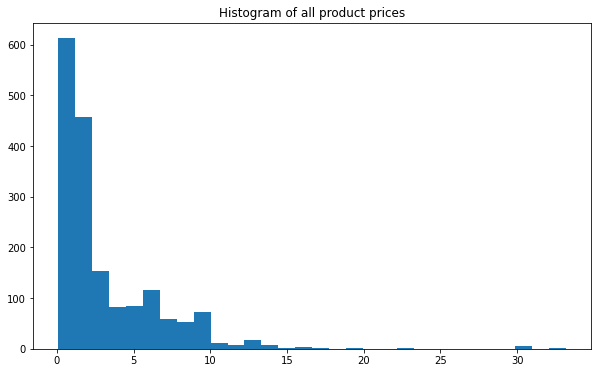

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df.Price, bins=30)
plt.title('Histogram of all product prices')
plt.show()

From the histogram above, we can see that the data is bounded on the left by 0 as expected (price should be positive), and the price in Euro (as asked for when filling out the form) per unit are mostly under 10, regardless of the product. Still, there are some extreme outliers to the right. These values need to be removed because they can significant impact on mean and standard deviation, which we may use to estimate hyperparameters later. As the distribution heavily skews right, we will use the interquantile range (IQR) to determine which data points are outliers to be removed. Note: different products would have different base prices, hence the distribution for each type of product won't be so skewed. We will choose outliers based on individual types of product to ensure variability.

Removed 10 outliers, 0.57% of data.


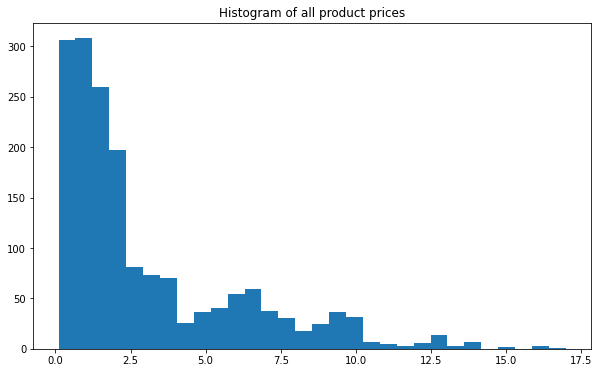

In [13]:
def IQR_boundaries(data, threshold=2.0):
    # Get the first quantile and the third quantile values
    # to calculate the IQR.
    q1, q3 = np.percentile(data,[25,75])
    iqr = q3 - q1
    # Calculate and the return the boundaries
    lower_bound = q1 -(threshold * iqr) 
    upper_bound = q3 +(threshold * iqr)
    return lower_bound, upper_bound

# Get a dict storing all prices for each product
price_dict = {}
groups = df.groupby('variable')
for product in products:
    price_dict[product] = groups.get_group(product)['Price']

# Initialize a dict to store the boundaries
boundaries_dict = {}
for product in products:
    boundaries_dict[product] = IQR_boundaries(price_dict[product])

# Get indices of outliers
outliers = []
n = df.shape[0]
for i in range(n):
    key = df.iloc[i, -2]
    price = df.iloc[i, -1]
    boundaries = boundaries_dict[product]
    if price < boundaries[0] or price > boundaries[1]:
        outliers.append(i)

# Remove outliers and reset index
df.drop(outliers, inplace=True)
df.reset_index(inplace=True, drop=True)
n_outliers = len(outliers)
print(f'Removed {n_outliers} outliers, {round(n_outliers*100/n, 2)}% of data.')

plt.figure(figsize=(10, 6))
plt.hist(df.Price, bins=30)
plt.title('Histogram of all product prices')
plt.show()

Lastly, export the processed dataset for modeling.

In [14]:
df.to_csv("processed_data.csv")